# Imports

In [1]:
import matplotlib.pyplot as plt
from loadfile import *
from phonemes import *
from preprocess import *
from evaluate import *
from google_kb_z_speaker.main import *
from tqdm.auto import tqdm
from experiment_helpers import *
from functools import partial
import numpy as np
import logging
from seqmatch import *
from google_kb_z_speaker.experiments import *
from google_kb_z_speaker.preprocessing import *

# Text processing

In [2]:
bunches = get_bunches("transcriptions")

# Experiments

# Ensemble evaluation

Here we evaluate the first ensemble created between Google and KB and perform a grid search to find the optimal phonemizer and ratio threshold

In [5]:
experiment = ensemble
kwargs = {
    "bunches" : bunches,
    "device" : "cuda"
}
args = [
    [
        #"./models/deep-phonemizer-se.pt",
        "./models/DeepPhon/winhome/Downloads/DeepPhon_to_send/best_model.pt",
        #"./models/DeepPhon/winhome/Downloads/DeepPhon_to_send/model_step_40k.pt"
    ],
    np.linspace(0.5,0.7,num=3)
]
res = grid(experiment,*args,**kwargs)
print_experiment_report(res)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/911 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [4]:
filtered = filter(lambda x : "nidek" in x[0][0] and x[0][1] >= 0.5 and x[0][1] > 0.6, res)
min(filtered, key= lambda x: x[1]["ensemble-wer"])

NameError: name 'res' is not defined

## Parameterized agreement

We relax the notion of agreement and we consider that KB and Google agree only when their lcs is over a percentage of their maximum length. We then consider that in cases of agreement we keep only the largest common subsequence (LCS) of the two as the prediction.

In the following cells we test this for different threshhold levels, we produce first the WERs per threshold level and also the percentage of utterances where there is agreement

In [13]:
experiment = parameterized_agreement
kwargs = {
    "_filter": None, 
    "phoneme_words" : False,
    "singular_phonemes" : False,
    "preprocess_hook" : None,
    "stress_marks" : True,
    "trusted_model" : "kb",
    "threshold_range" : (0,1)
}
res = experiment(bunches, "models/deep-phonemizer-se.pt", **kwargs)

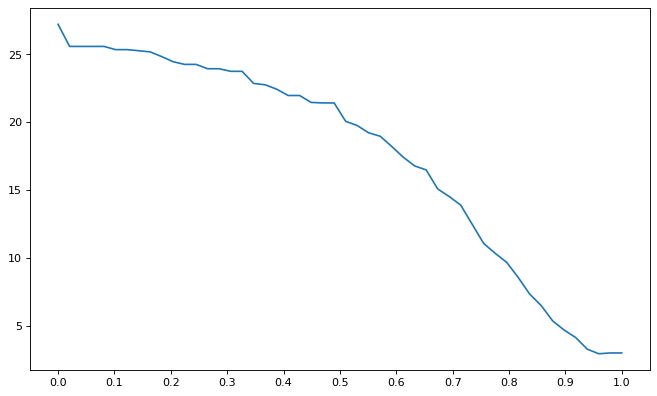

In [15]:
x = res["threshold_levels"]
y = res["agreement_wers"]

plt.figure(figsize=(10, 6), dpi=80)

plt.xticks(np.arange(min(x), max(x)+1, 0.1))
plt.plot(x, [yi * 100 for yi in y ])

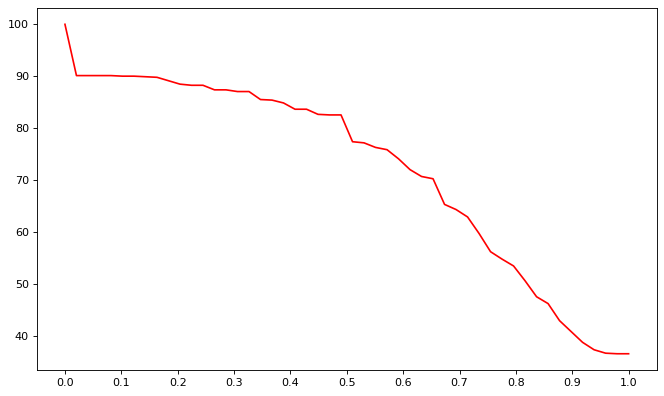

In [16]:
#fig, ax1 = plt.subplots()

#ax2 = ax1.twinx()
#ax2.set_ylim(0,100)
x = res["threshold_levels"]
y = res["agreement_ratios"]

plt.figure(figsize=(10, 6), dpi=80)

plt.xticks(np.arange(min(x), max(x)+1, 0.1))
plt.plot(x, [yi * 100 for yi in y ], "r")
#ax2.plot(res["threshold_levels"], [x * 100 for x in res["agreement_ratios"]], "r")
#plt.plot(res["threshold_levels"], [x * 10 for x in res["ensemble_wers"]])

## Pairwise evaluation

Here we test KB and Google, calculating their WERs under different scenarios (words, phoneme_words, singular phonemes) and also statistics percentages about 
agreement, overlap and mean-lcs

In [20]:
experiment = meval
_filter = {
    "agreement" : False,
    "g_correct" : False,
    "kb_correct" : False,
}
kwargs = {
    "_filter": None, 
    "phoneme_words" : False,
    "singular_phonemes" : False,
    "preprocess_hook" : None,
    "stress_marks" : True
}
res = experiment_repeats(experiment, 5, bunches, "./models/deep-phonemizer-se.pt", **kwargs)
print_experiment_report(res)

  0%|          | 0/5 [00:00<?, ?it/s]

agreement: 0.36553238199780463±0.0
g_correct_kb_not : 0.2768166089965398±0.0
kb_correct_g_not : 0.15051903114186851±0.0
agreement_not_correct: 0.0990990990990991±0.0
both_incorrect_disagreement: 0.5726643598615917±0.0
google_wer: 0.1983669548511047±0.0
kb_wer: 0.19164265129682997±0.0
google-avg-length: 6.300768386388584±0.0
correct-avg-length: 6.856201975850714±0.0
kb-avg-length: 6.711306256860593±0.0
lcs-mean: 0.7239754234570818±0.0
error_index_overlap: 0.3029810298102981±0.0


## Randomness in phonemizer

Here we explore the phenomenon that the phonemizer can output multiple pronounciations of some words, but refrains to do it when it is called with an argument that is List[str]

In [ ]:
phonemizer = phonemizer("Hello my name is nick", lang="se")

In [ ]:
set([phonemizer("ja", "se") for x in range(100)])

In [ ]:
set(phonemizer(["ja" for x in range(10000)], "se"))

# Error analysis

In [ ]:
bunch_list = [{k: bunches[k][i] for k in bunches} for i in range(len([x for x in bunches.values()][0]))]

In [ ]:
sorted_bunch_list = sorted(bunch_list, key=lambda x : wer(x["correct"], x["kb"]))

In [ ]:
sorted_bunch_list.reverse()

In [ ]:
sorted_bunch_list

In [ ]:
str_a

In [ ]:
s.get_matching_blocks()

In [ ]:
google_lines.index("30")

In [ ]:
set(phonemizer(["jag" for x in range(10000)], "se"))

In [ ]:
set(get_swedish_phonemes(["ja" for x in range(10000)], phonemizer))

In [ ]:
s = []
for x in tqdm(range(1000)):
    torch.manual_seed(0)
    s.append(phonemizer('30', "se"))
set(s)

In [ ]:
s = []
for x in tqdm(range(15)):
    #torch.manual_seed(0)
    s.append(get_swedish_phonemes('ja', phonemizer))
set(s)

# Visualization

In [ ]:
idx = 43
size = 10
def get_triad(idx, bunch):
    #### Google, correct, Kb
    return bunch[0][idx], bunch[1][idx], bunch[2][idx]

def plot_triad(triad,ax):
    ax.text(0.0, 0.0, triad[0], size=size, rotation=0,
             ha="center", va="center",
             bbox=dict(boxstyle="round",
                       ec=(1., 0.5, 0.5),
                       fc=(1., 0.8, 0.8),
                       )
             )

    ax.text(0, -2.5,  triad[2], size=size, rotation=0,
             ha="center", va="center",
             bbox=dict(boxstyle="round",
                       ec=(153/255, 51/255, 0/255),
                       fc=(255/255, 153/255, 102/255),
                       )
             )
    ax.text(0, -5,  triad[1], size=size, rotation=0,
             ha="center", va="center",
             bbox=dict(boxstyle="round",
                       ec=(42 / 255, 162 / 255, 42 / 255),
                       fc=(133 / 255, 224 / 255, 133 / 255),
                       )
             )
    
    ax.set_ylim(-10, 10)
    ax.set_xlim(-10, 10)

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))
idx = 0
plot_triad(get_triad(idx, text_data_bunch) ,axs[0])
plot_triad(get_triad(idx, phoneme_data_bunch) ,axs[1])

In [ ]:

def print_triad_correctness(triad):
    #### Google, correct, Kb
    print("Google correct ", triad[1] == triad[0])
    print("KB correct ", triad[1] == triad[2])
    print("Agreement ", triad[0] == triad[2])
    
    print("Google WER ", wer(triad[1], triad[0]))
    print("KB WER ", wer(triad[1], triad[2]))